In [51]:
import sys
sys.path.append('D:/UNESP/EngMec-UNESP/')
import frankenstein as fk

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import ZebraLib as zb
import uncertainties.unumpy as un


In [52]:
D1=0.0385; A1 = np.pi*(D1**2)/4
Dt=0.0257; At = np.pi*(Dt**2)/4
beta = Dt/D1

def f_distrib(delta_h):

    Vm = calc_vazão(delta_h)[2]
    hl = hl_(delta_h)

    D1=0.0385 #m
    L = 5     #m
    return (2*D1*hl)/(L*Vm**2)

def f_blassius(delta_h):
    Re = calc_vazão(delta_h)[1]
    return 0.316/(Re**0.25)

def calc_rugosidade(delta_h):

    Re = calc_vazão(delta_h)[1]

    def rugosidade(Rug, args):
        f = f_blassius(delta_h)
        #f = f_distrib(delta_h)

        A = ((Rug/3.7)**1.11) + (6.9/Re)
        return 1/np.sqrt(f) + 1.8*np.log10(A)
    Rug, it, res = zb.robustNewton(rugosidade, np.array([3e-4]), args=Re)
    return Rug

def hl_(delta_h):
    '''
    Calcula a perda de carga hl dado  
    diferença de H do tubo em U [cm] com água.
    '''
    delta_P = fk.rho_agua*fk.g*(delta_h/100)
    return delta_P/fk.rho_ar

def calc_vazão(delta_h):
    '''
    Calcula a vazão em massa, número de Reynouds e velocidade. Obs: delta_h [cm]
    '''
    D1=0.0385; A1 = np.pi*(D1**2)/4
    Dt=0.0257; At = np.pi*(Dt**2)/4
    beta = Dt/D1

    def residuo_Re(Re, delta_h):
        delta_P = fk.rho_agua*fk.g*(delta_h/100)

        C = 0.5959 + (0.0312*(beta**2.1)) - (0.184*beta**8) + ((91.71*beta**2.5)/(Re**0.75))
        K = C/np.sqrt(1 - beta**4)
        return ((fk.rho_ar*Re*fk.mi*A1)/D1) - (K*At*np.sqrt(2*fk.rho_ar*delta_P))
        
    Re, it, res = (zb.robustNewton(residuo_Re, np.array([1e6]), args=delta_h))
    
    dot_m = (fk.rho_ar*Re*fk.mi*A1)/D1
    velocidade = (Re*fk.mi)/D1
    return float(dot_m), float(Re), float(velocidade) #kg/s, adim, m/s

def vazão_from_dataframe(df_, key=0):
    '''
    Calcula a vazão em massa, número de Reynouds e velocidade e retorna em um Dataframe. Obs: delta_h [cm]
    '''
    arr_po = np.zeros((df_.shape[0], df_.shape[1]-2))
    for j in range(arr_po.shape[1]):
        col_nome = ['PO_TL', 'PO_TR'][j]
        for i in range(arr_po.shape[0]):
            delta_h = df_[col_nome].values[i]
            arr_po[i, j] = calc_vazão(delta_h)[key] #[0]kg/s, [1]adim, [2]m/s
            
    return pd.DataFrame(arr_po, columns=['PO_TL', 'PO_TR'])

In [53]:
def incerteza_grupos(df):
    index_grup =  [[0, 4], [4, 8], [8, 12], [12, 16]]
    concat_df = pd.DataFrame()
    for j in range(df.shape[1]):
        nome_col = df.columns[j]
        nominal_values, std_devs = [], []
        for i in range(4):
            values = df[nome_col][index_grup[i][0]:index_grup[i][1]].values
            nominal_values.append(values.mean())
            std_devs.append(values.std(ddof=1)/np.sqrt(len(values)))
            res = un.uarray(nominal_values, std_devs) 
        
        df1 = pd.DataFrame({f'{df.columns[j]}':res})
        concat_df = pd.concat([concat_df, df1], axis=1)
    return concat_df
    #print(concat_df.to_latex(index=0))

### Dados

In [54]:
df = pd.read_excel('D:/UNESP/EngMec-UNESP/Lab. Mec Flu II/Lab 4 - Comparação entre perdas de carga/dados.xlsx', 
                    sheet_name='dados_liq')
#print(df.to_latex(index=0))
incerteza_grupos(df)

,PO_TL,TL,PO_TC,TC
0,6.225+/-0.025,1.775+/-0.025,4.2000000000000002+/-0.0000000000000009,6.075+/-0.025
1,13.62+/-0.08,3.60+/-0.19,7.550+/-0.029,10.73+/-0.13
2,17.025+/-0.025,4.10+/-0.12,8.30+/-0.04,14.2+/-2.5
3,18.72+/-0.09,4.575+/-0.025,8.650+/-0.029,12.10+/-0.06


### $R_e$ e perda de carga $H_l$

In [55]:
df_ = df

arr_po = np.zeros((df_.shape[0], df_.shape[1]))
for j in range(arr_po.shape[1]):
    col_nome = ['PO_TL', 'PO_TC', 'TL', 'TC'][j]
    fun = [calc_vazão, calc_vazão, hl_, hl_]
    for i in range(arr_po.shape[0]):

        delta_h = df_[col_nome].values[i]

        if j == 0 or j == 1:
            value = fun[j](delta_h)[1]
        else:
            value = fun[j](delta_h)

        arr_po[i, j] = value #[0]kg/s, [1]adim, [2]m/s
        
df1 = pd.DataFrame(arr_po, columns=['Re_TL', 'Re_TC', 'h_TL', 'h_TC'])
incerteza_grupos(df1)

,Re_TL,Re_TC,h_TL,h_TC
0,(2.103+/-0.004)e+04,17354.3153778822+/-0.0000000016,152.3+/-2.1,521.2+/-2.1
1,(3.087+/-0.008)e+04,(2.311+/-0.004)e+04,309+/-16,920+/-11
2,34443+/-25,(2.421+/-0.006)e+04,352+/-11,(1.22+/-0.21)e+03
3,(3.610+/-0.008)e+04,(2.470+/-0.004)e+04,392.5+/-2.1,1038+/-5


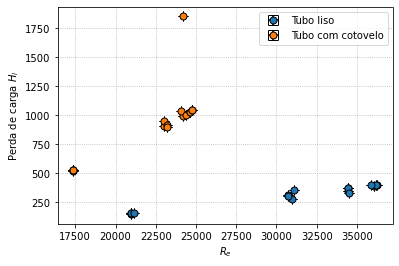

In [56]:
#%matplotlib
fig, ax = plt.subplots()
ax.set(xlabel=r'$R_e$', ylabel=r'Perda de carga $H_l$')
fk.error(df1['Re_TL'].values, df1['h_TL'].values, mark='o', tipo='Tubo liso', ax=ax)
fk.error(df1['Re_TC'].values, df1['h_TC'].values, mark='o', tipo='Tubo com cotovelo', ax=ax)

ax.grid(ls='dotted')
ax.legend()

fig.savefig('Hl_x_Re.pdf', bbox_inches='tight')

### Estimando perda localizada

Tirando a perda total pelo tubo com cotovelo subtraido do tubo liso. Para descobrir perda de carga somente pelos cotovelos.

In [57]:
#Estimando perda localizada 
df1['H_local'] = df1['h_TC']-df1['h_TL']
df1['Perc_perda'] = df1['H_local']/df1['h_TC']*100  
df1.drop(columns=['Re_TL'])

,Re_TC,h_TL,h_TC,H_local,Perc_perda
0,17354.315378,145.850605,514.766842,368.916237,71.666667
1,17354.315378,154.430053,523.346289,368.916237,70.491803
2,17354.315378,154.430053,523.346289,368.916237,70.491803
3,17354.315378,154.430053,523.346289,368.916237,70.491803
4,23033.697473,351.757342,909.421421,557.664079,61.320755
5,23033.697473,274.542316,952.318658,677.776342,71.171171
6,23183.506963,308.860105,918.000868,609.140763,66.355140
7,23183.506963,300.280658,900.841974,600.561316,66.666667
8,24205.537752,343.177895,995.215895,652.038000,65.517241
9,24205.537752,368.916237,1853.160632,1484.244395,80.092593


In [58]:
incerteza_grupos(df1.drop(columns=['Re_TL']))

,Re_TC,h_TL,h_TC,H_local,Perc_perda
0,17354.3153778822+/-0.0000000016,152.3+/-2.1,521.2+/-2.1,368.9162368421054+/-0,70.79+/-0.29
1,(2.311+/-0.004)e+04,309+/-16,920+/-11,611+/-25,66.4+/-2.0
2,(2.421+/-0.006)e+04,352+/-11,(1.22+/-0.21)e+03,(8.7+/-2.0)e+02,69+/-4
3,(2.470+/-0.004)e+04,392.5+/-2.1,1038+/-5,646+/-4,62.19+/-0.18


In [59]:
print(incerteza_grupos(df1.drop(columns=['Re_TL'])).to_latex(index=0))

\begin{tabular}{lllll}
\toprule
                           Re\_TC &         h\_TL &               h\_TC &                H\_local &    Perc\_perda \\
\midrule
 17354.3153778822+/-0.0000000016 &  152.3+/-2.1 &        521.2+/-2.1 &  368.9162368421054+/-0 &  70.79+/-0.29 \\
             (2.311+/-0.004)e+04 &     309+/-16 &           920+/-11 &               611+/-25 &    66.4+/-2.0 \\
             (2.421+/-0.006)e+04 &     352+/-11 &  (1.22+/-0.21)e+03 &        (8.7+/-2.0)e+02 &        69+/-4 \\
             (2.470+/-0.004)e+04 &  392.5+/-2.1 &           1038+/-5 &                646+/-4 &  62.19+/-0.18 \\
\bottomrule
\end{tabular}



### $\dot{m}$ e perda de carga $H_l$

In [60]:
df_ = df

arr_po = np.zeros((df_.shape[0], df_.shape[1]))
for j in range(arr_po.shape[1]):
    col_nome = ['PO_TL', 'PO_TC', 'TL', 'TC'][j]
    fun = [calc_vazão, calc_vazão, hl_, hl_]
    for i in range(arr_po.shape[0]):

        delta_h = df_[col_nome].values[i]

        if j == 0 or j == 1:
            value = fun[j](delta_h)[0]
        else:
            value = fun[j](delta_h)

        arr_po[i, j] = value #[0]kg/s, [1]adim, [2]m/s
        
df2 = pd.DataFrame(arr_po, columns=['m_TL', 'm_TC', 'h_TL', 'h_TC'])
incerteza_grupos(df2)

,m_TL,m_TC,h_TL,h_TC
0,0.013409+/-0.000026,0.0110671214572849+/-0.0000000000000010,152.3+/-2.1,521.2+/-2.1
1,0.01969+/-0.00005,0.014737+/-0.000028,309+/-16,920+/-11
2,0.021965+/-0.000016,0.01544+/-0.00004,352+/-11,(1.22+/-0.21)e+03
3,0.02302+/-0.00005,0.015752+/-0.000026,392.5+/-2.1,1038+/-5


### Calculando $H_{lm}$ associado a $K$ para tubo com cotovelo  

### 

In [61]:
df_ = df

arr_po = np.zeros((df_.shape[0], df_.shape[1]-2))

for j in range(arr_po.shape[1]):
    col_nome = ['PO_TC', 'H_local'][j]
    df_ = [df, df1][j]
    fun = [calc_vazão, hl_]
    
    for i in range(arr_po.shape[0]):

        delta_h = df_[col_nome].values[i]

        if j == 0:
            m, re, v = fun[j](delta_h)
            value = v
        else:
            #m, re, v, k = fun[j](delta_h)
            value = df_[col_nome].values[i]

        arr_po[i, j] = value #[0]kg/s, [1]adim, [2]m/s
        
df3 = pd.DataFrame(arr_po, columns=['v_TC', 'H_local'])
df3['Re'] = (df3['v_TC']*D1)/fk.mi
df3['K'] = ((df3['H_local']/(df3['v_TC']**2))*2)/8


print(incerteza_grupos(df3.drop(columns=['v_TC', 'H_local']))
.to_latex(index=0))

\begin{tabular}{ll}
\toprule
                              Re &                                    K \\
\midrule
 17354.3153778822+/-0.0000000016 &  1.32626652964116+/-0.00000000000025 \\
             (2.311+/-0.004)e+04 &                          1.24+/-0.05 \\
             (2.421+/-0.006)e+04 &                            1.6+/-0.4 \\
             (2.470+/-0.004)e+04 &                        1.146+/-0.004 \\
\bottomrule
\end{tabular}



### Comprimento equivalente $L_e$

In [66]:
df3['f'] = 64/df1['Re_TC']
df3['Re'] = df1['Re_TC']
df3['Le'] = (df3['K']*D1)/(64/df1['Re_TC'])
#df3['Le'] = (df3['K']*D1)/(0.316/df1['Re_TC']**0.25)
#df3['Eq_len'] = (df3['Le']/D1)
df3

df3.drop(columns=['v_TC', 'H_local'])

,Re,K,f,Le
0,17354.315378,1.326267,0.003688,13.845832
1,17354.315378,1.326267,0.003688,13.845832
2,17354.315378,1.326267,0.003688,13.845832
3,17354.315378,1.326267,0.003688,13.845832
4,23033.697473,1.138055,0.002779,15.769132
5,23033.697473,1.383175,0.002779,19.165560
6,23183.506963,1.227093,0.002761,17.113439
7,23183.506963,1.209810,0.002761,16.872405
8,24205.537752,1.204929,0.002644,17.545144
9,24205.537752,2.742799,0.002644,39.938288


In [63]:
print(incerteza_grupos(df3.drop(columns=['v_TC', 'H_local'])).to_latex(index=0))

\begin{tabular}{llll}
\toprule
                              Re &                                    K &                                          f &                                  Le \\
\midrule
 17354.3153778822+/-0.0000000016 &  1.32626652964116+/-0.00000000000025 &  0.00368784354821435+/-0.00000000000000034 &  13.8458317777360+/-0.0000000000013 \\
             (2.311+/-0.004)e+04 &                          1.24+/-0.05 &                        0.002770+/-0.000005 &                          17.2+/-0.7 \\
             (2.421+/-0.006)e+04 &                            1.6+/-0.4 &                        0.002644+/-0.000006 &                              23+/-6 \\
             (2.470+/-0.004)e+04 &                        1.146+/-0.004 &                        0.002591+/-0.000004 &                        17.02+/-0.08 \\
\bottomrule
\end{tabular}

